# Setup

In [1]:
%%capture
!pip install --upgrade scikit-learn

In [2]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import (
    make_column_transformer, 
    make_column_selector
)
from sklearn.preprocessing import (
    StandardScaler, 
    TargetEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor
)
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

SEED = 2024

In [3]:
data = pd.read_csv('/kaggle/input/used-cars-price-prediction/train-data.csv')

# Data Overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [5]:
data.sample(3)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
520,520,Maruti Celerio VXI,Jaipur,2014,56000,Petrol,Manual,First,23.1 kmpl,998 CC,67.04 bhp,5.0,NaN,2.79
3332,3332,Mahindra Quanto C6,Mumbai,2013,35000,Diesel,Manual,First,17.21 kmpl,1493 CC,100 bhp,7.0,NaN,3.49
5403,5403,Honda Amaze S i-Dtech,Kolkata,2013,46992,Diesel,Manual,First,25.8 kmpl,1498 CC,98.6 bhp,5.0,NaN,3.75


In [6]:
TARGET = 'Price'
data[TARGET].describe()

count    6019.000000
mean        9.479468
std        11.187917
min         0.440000
25%         3.500000
50%         5.640000
75%         9.950000
max       160.000000
Name: Price, dtype: float64

In [7]:
data['Unnamed: 0'].nunique(), data.shape[0]

(6019, 6019)

First column is the unique identifier, so we can drop it before further analysis.

In [8]:
data = data.drop('Unnamed: 0', axis=1)

# Data exploration + cleaning

### TARGET: Price

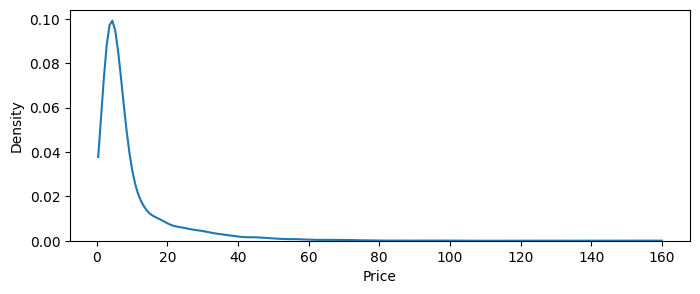

In [9]:
plt.figure(figsize=(8, 3))
sns.kdeplot(x=TARGET, data=data, cut=0)
plt.show()

Cars in the luxury segment are fewer in number but have very high prices, which can misguide our model.  
We will apply z-score method to the target to remove the very high priced cars i.e., luxury segment.

In [10]:
data[TARGET].mean() + data[TARGET].std() * 3

43.043219687590785

In [11]:
data = data.query("Price <= 43")

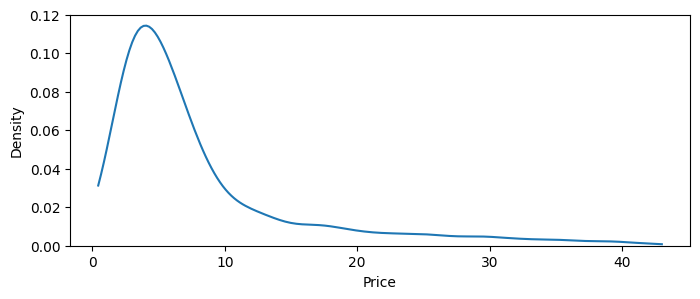

In [12]:
plt.figure(figsize=(8, 3))
sns.kdeplot(x=TARGET, data=data, cut=0)
plt.show()

### Name

In [13]:
data.Name.nunique()

1819

In [14]:
data.Name.value_counts()

Name
Mahindra XUV500 W8 2WD            49
Maruti Swift VDI                  45
Honda City 1.5 S MT               34
Maruti Swift Dzire VDI            34
Maruti Swift VDI BSIV             31
                                  ..
Hyundai i20 2015-2017 Asta         1
Maruti Omni 5 Str STD              1
Volkswagen Passat Highline DSG     1
Hyundai i20 Active S Diesel        1
Mahindra Xylo D4 BSIV              1
Name: count, Length: 1819, dtype: int64

In [15]:
data['Brand'] = data.Name.apply(lambda x: x.lower().split(' ')[0])

In [16]:
data.Brand.unique()

array(['maruti', 'hyundai', 'honda', 'audi', 'nissan', 'toyota',
       'volkswagen', 'tata', 'land', 'mitsubishi', 'renault',
       'mercedes-benz', 'bmw', 'mahindra', 'ford', 'porsche', 'datsun',
       'jaguar', 'volvo', 'chevrolet', 'skoda', 'mini', 'fiat', 'jeep',
       'smart', 'ambassador', 'isuzu', 'force'], dtype=object)

In [17]:
data.Brand.value_counts()

Brand
maruti           1211
hyundai          1107
honda             608
toyota            411
volkswagen        315
ford              299
mercedes-benz     274
mahindra          272
bmw               229
audi              213
tata              186
skoda             173
renault           145
chevrolet         121
nissan             91
land               40
jaguar             30
fiat               28
mitsubishi         27
mini               26
volvo              21
jeep               15
datsun             13
porsche             7
isuzu               3
force               3
smart               1
ambassador          1
Name: count, dtype: int64

Removing rare brands:

In [18]:
data = data.query("Brand not in ('isuzu', 'force', 'smart', 'ambassador', 'porsche')").reset_index(drop=True)

In [19]:
data.groupby('Brand')[TARGET].describe()

,count,mean,std,min,25%,50%,75%,max
Brand,,,,,,,,
audi,213.0,22.648920,8.615082,7.50,16.5000,22.500,27.5000,43.00
bmw,229.0,20.501921,9.050736,6.30,12.9500,18.550,28.0000,43.00
chevrolet,121.0,3.044463,1.827563,0.75,1.7500,2.500,3.7000,9.87
datsun,13.0,3.049231,0.476156,2.25,2.7000,3.100,3.3100,3.95
fiat,28.0,3.269286,1.901356,0.55,2.0875,2.600,4.7000,7.71
ford,299.0,6.722475,6.941409,0.69,2.7500,5.340,7.3400,35.50
honda,608.0,5.411743,2.541032,0.90,3.5400,4.950,6.5850,17.50
hyundai,1107.0,5.343433,3.311355,0.45,3.0950,4.600,6.4500,23.00
jaguar,30.0,29.113333,6.286310,16.00,25.9000,29.250,33.4225,40.00


Different brands have cars in different price segments, making it a good candidate for target encoding.

### Location

In [20]:
data.groupby('Location')[TARGET].describe()

,count,mean,std,min,25%,50%,75%,max
Location,,,,,,,,
Ahmedabad,223.0,8.114081,6.687343,0.75,3.7750,5.900,10.5000,35.00
Bangalore,341.0,11.035337,9.712303,1.35,4.4000,6.600,16.2500,43.00
Chennai,482.0,6.738465,6.641608,0.65,2.8000,4.500,7.2875,38.00
Coimbatore,589.0,11.955161,9.801062,1.68,5.5600,7.720,14.3000,42.83
Delhi,542.0,8.538432,7.904311,0.75,3.5550,5.500,10.5375,42.75
Hyderabad,724.0,8.538950,8.037035,0.60,3.5000,5.725,9.3250,43.00
Jaipur,411.0,5.769367,5.867929,0.45,2.5000,4.250,6.4500,42.50
Kochi,629.0,9.616359,7.904490,1.26,4.7300,6.610,10.6000,40.47
Kolkata,529.0,5.239603,5.025839,0.65,2.6000,3.600,5.7500,39.75


Can be one-hot or target encoded for sklearn models. Can be handled directly by gradient boosting libraries.

### Year

In [21]:
def plot_num(f, clip=None):
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
    if clip:
        dataset = data.loc[(data[f] >= clip[0]) & (data[f] <= clip[1])]
    else:
        dataset = data
    sns.histplot(x=f, data=dataset, kde=True, ax=ax[0])
    sns.scatterplot(x=f, y=TARGET, data=dataset)
    fig.tight_layout()
    plt.show()

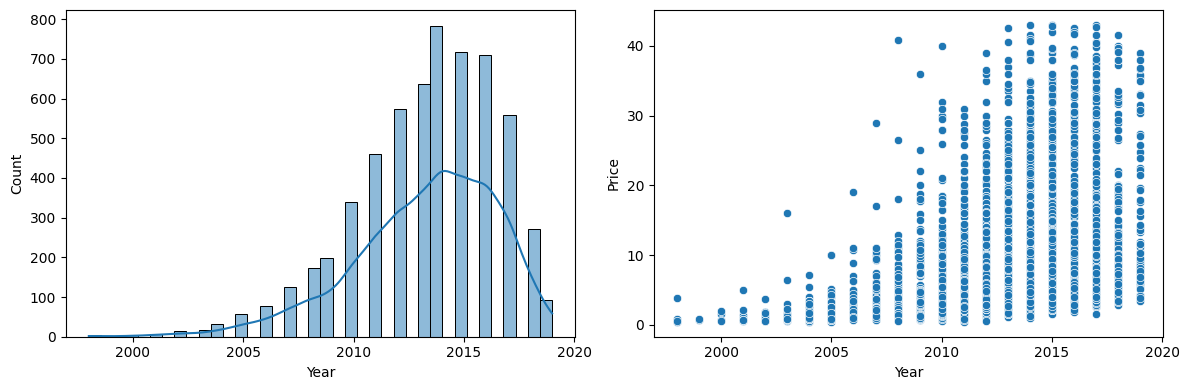

In [22]:
plot_num('Year')

Older cars have lower prices. Newer cars may have low or high prices based on their segment.

### Kilometers_Driven

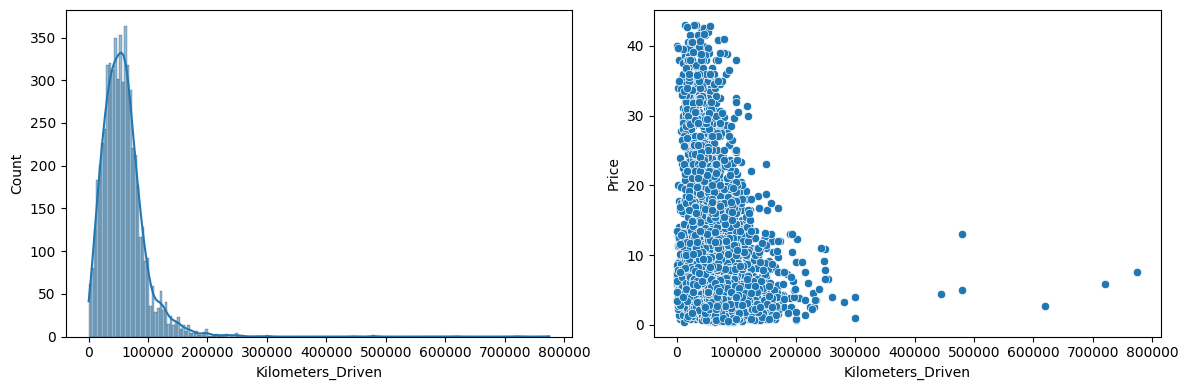

In [23]:
plot_num('Kilometers_Driven')

In [24]:
data['Kilometers_Driven'].mean() + data['Kilometers_Driven'].std() * 3

172411.2248301885

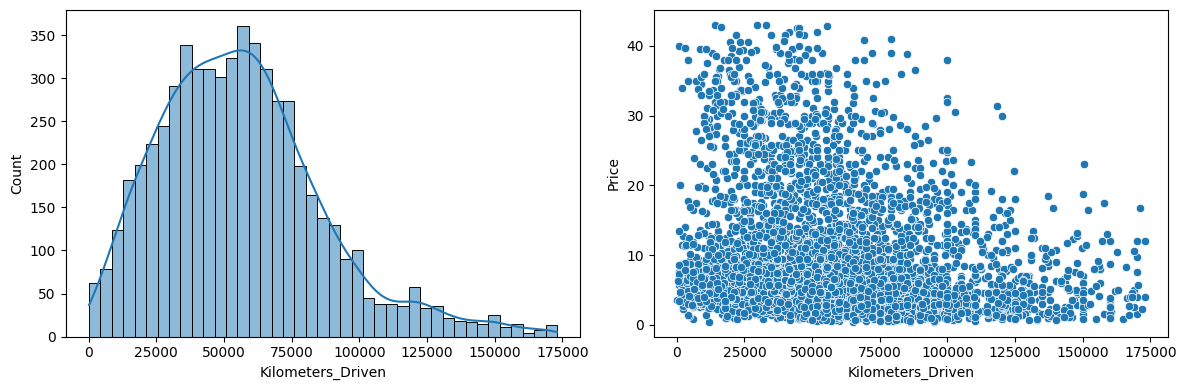

In [25]:
plot_num('Kilometers_Driven', clip=(0, 175000))

Prices are generally lower for cars that have been driven more.  

We can remove some of the extreme outliers which will affect our feature scaling, with some relaxation to our z-score limit. 

In [26]:
data = data.query("Kilometers_Driven <= 3e5")

### Fuel_Type

In [27]:
data.Fuel_Type.value_counts(normalize=True)

Fuel_Type
Diesel      0.523850
Petrol      0.464524
CNG         0.009574
LPG         0.001710
Electric    0.000342
Name: proportion, dtype: float64

Categories other than Petrol and Diesel combine to barely cover 1% of the data.  
We can drop these rows and focus our model on petrol vs diesel cars.

In [28]:
data = data.query("Fuel_Type in ('Petrol', 'Diesel')")

In [29]:
data.groupby('Fuel_Type')[TARGET].describe()

,count,mean,std,min,25%,50%,75%,max
Fuel_Type,,,,,,,,
Diesel,3064.0,11.03154,9.031551,0.60,4.75,7.495,14.50,43.0
Petrol,2717.0,5.18594,4.535242,0.44,2.70,4.050,6.06,41.5


Diesel cars have higher prices in general.  
We can encode this feature as a binary variable.

In [30]:
data['Fuel_Type'] = data.Fuel_Type.replace({'Petrol': 0, 'Diesel': 1}).astype('int8')

### Transmission

In [31]:
data.groupby('Transmission')[TARGET].describe()

,count,mean,std,min,25%,50%,75%,max
Transmission,,,,,,,,
Automatic,1559.0,16.227614,10.342416,1.50,7.38,14.050,23.68,43.00
Manual,4222.0,5.351016,3.562520,0.44,3.00,4.585,6.58,40.88


Automatic transmission cars have higher prices in general.  
We can encode this feature as a binary variable.

In [32]:
data['Transmission'] = data.Transmission.replace({'Manual': 0, 'Automatic': 1}).astype('int8')

### Owner_Type

In [33]:
data.Owner_Type.unique()

array(['First', 'Second', 'Fourth & Above', 'Third'], dtype=object)

In [34]:
data.groupby('Owner_Type')[TARGET].describe()

,count,mean,std,min,25%,50%,75%,max
Owner_Type,,,,,,,,
First,4723.0,8.674207,7.954809,0.50,3.7500,5.84,9.6750,43.0
Fourth & Above,9.0,3.280000,1.316378,1.97,2.2000,3.00,4.0000,5.5
Second,940.0,6.907106,7.272213,0.44,2.4425,4.25,8.0275,43.0
Third,109.0,3.673028,3.596291,0.45,1.3000,2.65,4.1100,21.0


The feature is available as a categorical variable but we can see that it is actually a numerical variable equivalent to "Number of previous owners".  
Prices keep dropping for cars which have more previous owners.

In [35]:
# last category is rare hence combined with the previous one
owner_mapping = {'First': 0, 'Second': 1, 'Third': 2, 'Fourth & Above': 2}
data['Num_Previous_Owners'] = data.Owner_Type.replace(owner_mapping).astype('int')

### Mileage

In [36]:
data.Mileage.sample(5, random_state=SEED)

5132    23.1 kmpl
4153    22.7 kmpl
4742    13.1 kmpl
2730    15.1 kmpl
5581    21.0 kmpl
Name: Mileage, dtype: object

In [37]:
data.Mileage.apply(lambda x: x.split(' ')[1]).value_counts()

Mileage
kmpl    5781
Name: count, dtype: int64

Since the units are consistent, we can directly extract the value as a continuous variable.

In [38]:
data['Mileage'] = data.Mileage.apply(lambda x: float(x.split(' ')[0]))

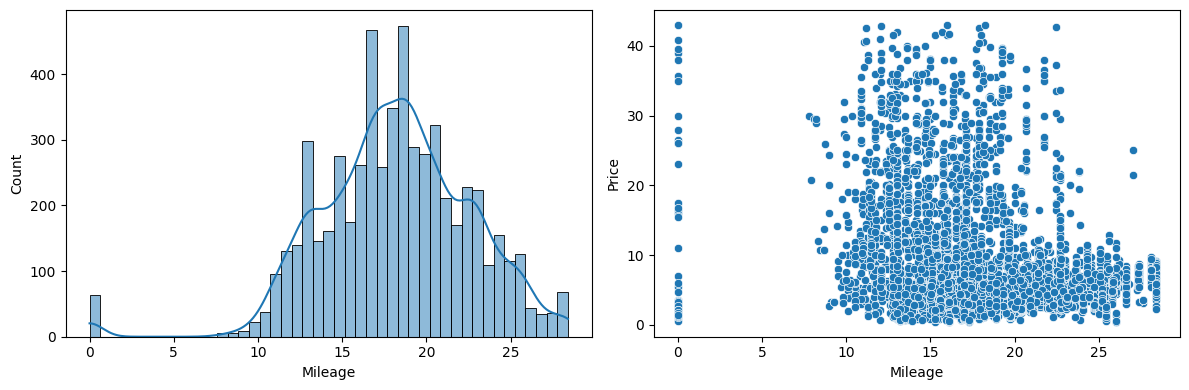

In [39]:
plot_num('Mileage')

Zero mileage is a logical error. We can replace these with NaN to mark them as missing.

In [40]:
data.loc[data.Mileage == 0.0, 'Mileage'] = np.NaN

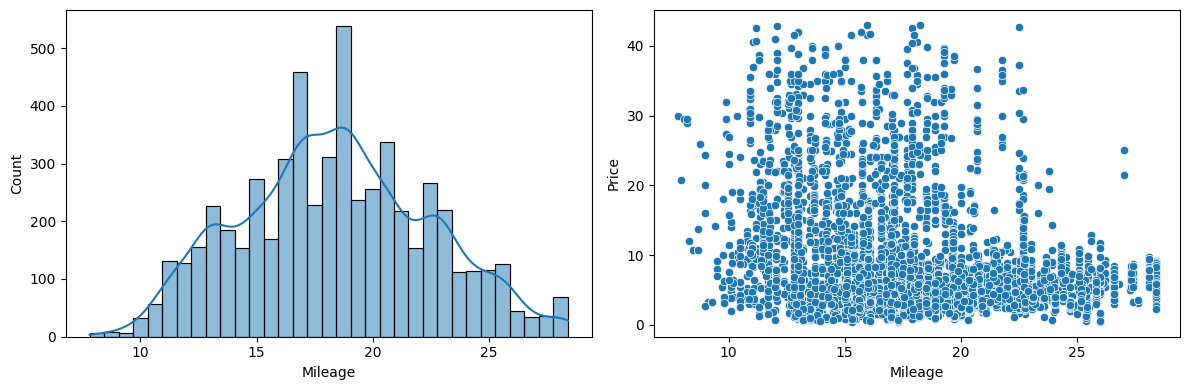

In [41]:
plot_num('Mileage')

We can see a section of high-mileage cars with lower prices. These probably belong to the economy segment.

### Engine

In [42]:
data.Engine.sample(5, random_state=SEED)

5132     998 CC
4153     799 CC
4742    2499 CC
2730    2179 CC
5581    1461 CC
Name: Engine, dtype: object

In [43]:
data.Engine.isna().sum()

36

Before processing the string values, we need to fill missing values to avoid mixed types.

In [44]:
data['Engine'] = data.Engine.fillna('0 CC')

In [45]:
data.Engine.apply(lambda x: x.split(' ')[1]).value_counts()

Engine
CC    5781
Name: count, dtype: int64

Units are consistent.

In [46]:
data['Engine'] = data.Engine.apply(lambda x: int(x.split(' ')[0]))

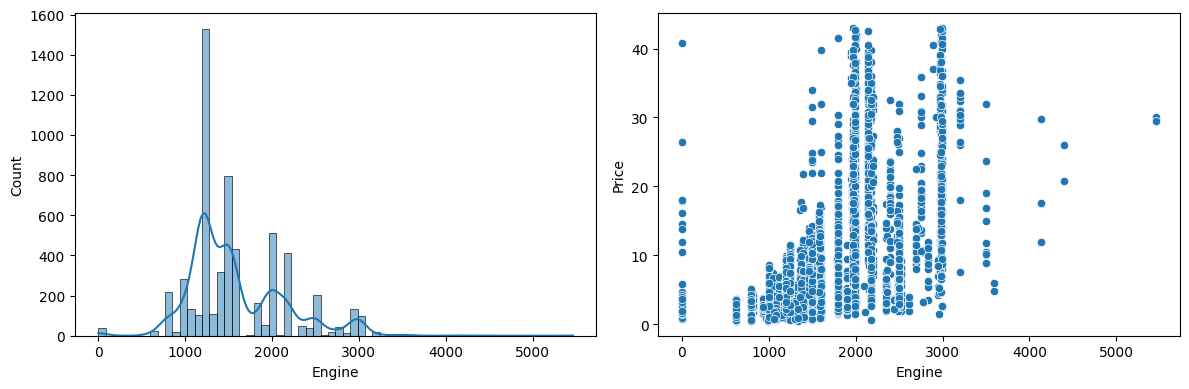

In [47]:
plot_num('Engine')

In [48]:
len(data.query("Engine == 0"))

36

These are the missing values we filled with '0 CC'.

In [49]:
data.loc[data.Engine == 0, 'Engine'] = np.NaN

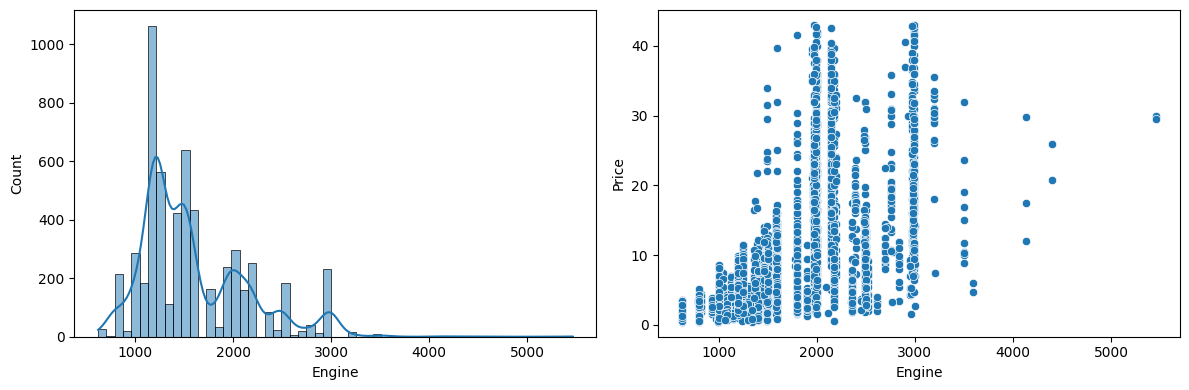

In [50]:
plot_num('Engine')

Low-capacity engines have lower prices but mid-capacity engines vary across the entire range of prices.

In [51]:
data['Engine'].mean() + data['Engine'].std() * 3

3233.294880071155

In [52]:
data = data.query("Engine.isna() or Engine < 3500")

### Power

In [53]:
data.Power.sample(5, random_state=SEED)

3686     55.2 bhp
1644      143 bhp
196       100 bhp
3243      118 bhp
3553    81.83 bhp
Name: Power, dtype: object

In [54]:
data.Power.isna().sum()

36

In [55]:
len(data.query("Power == 'null bhp'"))

103

This case also needs to be handled during conversion to float.

In [56]:
data['Power'] = data.Power.fillna('null bhp')

In [57]:
data.Power.apply(lambda x: x.split(' ')[1]).value_counts()

Power
bhp    5772
Name: count, dtype: int64

Units are consistent.

In [58]:
def power_to_float(value):
    power = value.split(' ')[0]
    if power == 'null':
        return np.NaN
    else:
        return float(power)
    

data['Power'] = data.Power.apply(power_to_float)

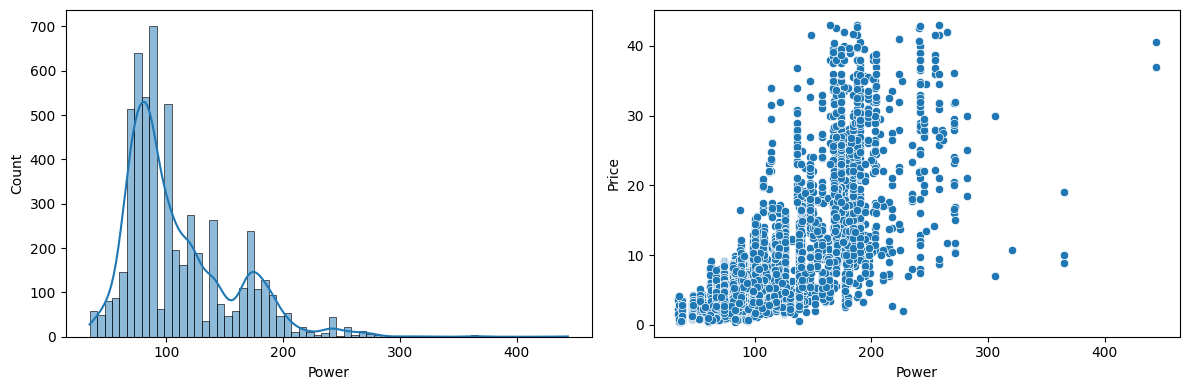

In [59]:
plot_num('Power')

In [60]:
len(data.query("Power <= 0"))

0

In [61]:
data.Power.mean() + data.Power.std() * 3

245.92972676005627

In [62]:
data = data.query("Power.isna() or Power < 300")

### Seats

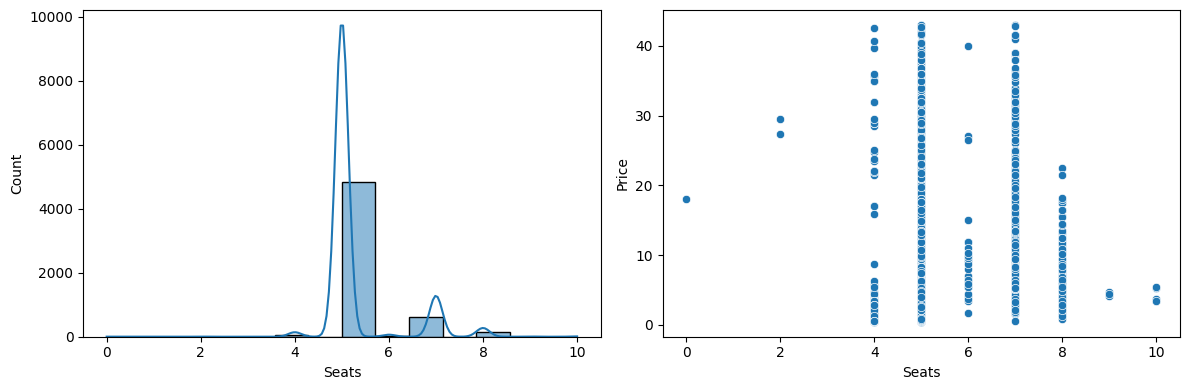

In [63]:
plot_num('Seats')

In [64]:
data.query("Seats < 4")

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand,Num_Previous_Owners
537,Audi TT 2.0 TFSI,Delhi,2013,12100,0,1,First,9.9,1984.0,207.8,2.0,NaN,29.50,audi,0
1244,Audi TT 2.0 TFSI,Kochi,2014,14262,0,1,First,9.9,1984.0,207.8,2.0,NaN,27.35,audi,0
3892,Audi A4 3.2 FSI Tiptronic Quattro,Hyderabad,2012,125000,0,1,First,10.5,3197.0,NaN,0.0,NaN,18.00,audi,0


In [65]:
data.query("Seats > 8")

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand,Num_Previous_Owners
784,Toyota Qualis FS B2,Pune,2004,77757,1,0,Second,13.10,2446.0,75.0,10.0,NaN,3.50,toyota,1
884,Tata Sumo DX,Mumbai,2013,20000,1,0,First,14.07,1978.0,83.1,10.0,NaN,5.25,tata,0
1302,Mahindra Scorpio LX BS IV,Bangalore,2007,74112,1,0,First,12.05,2179.0,120.0,9.0,NaN,4.10,mahindra,0
1848,Toyota Qualis FS B3,Bangalore,2002,63000,1,0,Third,13.10,2446.0,75.0,10.0,NaN,3.65,toyota,2
2199,Toyota Qualis RS E2,Pune,2004,215750,1,0,Second,NaN,2446.0,NaN,10.0,NaN,3.50,toyota,1
2242,Chevrolet Tavera LT 9 Str BS IV,Kolkata,2012,67132,1,0,First,13.58,2499.0,78.0,9.0,NaN,4.75,chevrolet,0
2287,Mahindra Xylo D2 Maxx,Chennai,2016,150000,1,0,First,14.95,2489.0,93.7,9.0,NaN,4.50,mahindra,0
2495,Chevrolet Tavera LS B3 10 Seats BSIII,Hyderabad,2015,120000,1,0,First,14.80,2499.0,80.0,10.0,NaN,5.50,chevrolet,0


The 2-seaters are luxury cars while the 10 seaters are older models that are often used as long-distance taxis, hence the inverted prices.

### New_Price

In [66]:
data.New_Price.value_counts(normalize=True, dropna=False)

New_Price
NaN           0.866586
63.71 Lakh    0.001041
4.78 Lakh     0.001041
11.67 Lakh    0.000867
44.28 Lakh    0.000867
                ...   
12.51 Lakh    0.000173
9.74 Lakh     0.000173
60.59 Lakh    0.000173
11.77 Lakh    0.000173
9.93 Lakh     0.000173
Name: proportion, Length: 503, dtype: float64

~87% of the values are missing.  
Although the feature would be very informative logically, too many values are missing from a modeling perspective.  
Hence, we will drop it from our features.

### Brand (revisited)

After removing outliers from other columns, there might be some other brands which are rare in the dataset now.
We must check for them before proceeding.

In [67]:
data['Brand'].value_counts()

Brand
maruti           1157
hyundai          1096
honda             607
toyota            409
volkswagen        313
ford              299
mahindra          271
mercedes-benz     269
bmw               224
audi              208
tata              184
skoda             170
renault           145
chevrolet         121
nissan             91
land               40
jaguar             30
fiat               28
mitsubishi         27
mini               26
volvo              21
jeep               15
datsun             13
Name: count, dtype: int64

No new rare cases.

# Feature selection

In [68]:
features = [
    'Brand', 
    'Location', 
    'Year', 
    'Kilometers_Driven', 
    'Fuel_Type', 
    'Transmission',
    'Num_Previous_Owners',
    'Mileage',
    'Engine',
    'Power',
    'Seats'
]

In [69]:
num_features = ['Year', 'Kilometers_Driven', 'Num_Previous_Owners', 'Mileage', 'Engine', 'Power', 'Seats']
cat_features = ['Fuel_Type', 'Transmission']  # Brand and Location will be target-encoded

### Pearson correlation

In [70]:
def plot_heatmap(df, masking=True, size=5):
    mask = np.triu(np.ones_like(df)) if masking else None
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(
        data=df, mask=mask,
        vmin=-1, vmax=1, center=0,
        annot=True, linewidths=0.1,
        fmt='.2f', annot_kws={'fontsize': 8})
    plt.show()

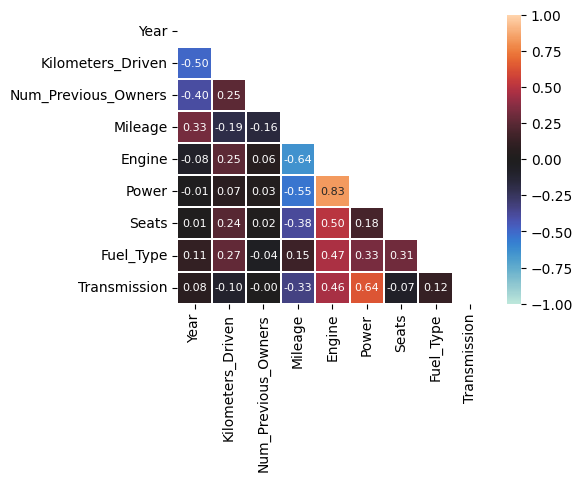

In [71]:
corr_df = data[num_features+cat_features].corr(method='pearson')
plot_heatmap(corr_df)

In [72]:
def plot_bars(scores, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, len(scores)*0.5))
    ax.set_title(title)
    sns.barplot(x=scores.values, y=scores.index, ax=ax)
    for patch in ax.patches:
        y, height, width = patch.get_y(), patch.get_height(), patch.get_width()
        ax.text(
            width+0.0001, y + height/2, 
            f'{width:.4f}', va='center', ha='left', size=8, 
            bbox={'facecolor': 'white', 'boxstyle': 'round'}
        )

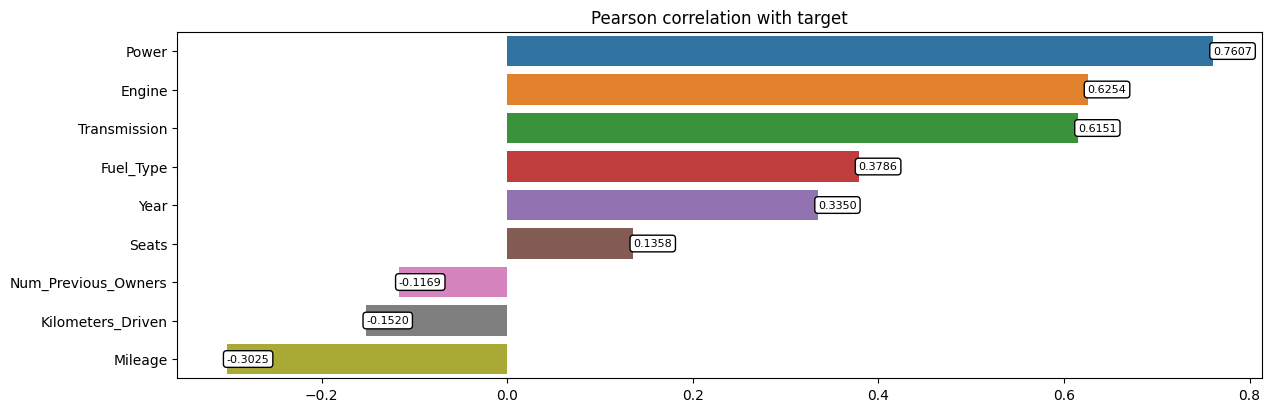

In [73]:
corr_target = data[num_features+cat_features].corrwith(data[TARGET]).sort_values(ascending=False)
plot_bars(corr_target, "Pearson correlation with target")

### Mutual Information scores

In [74]:
#boolean mask for discrete features (includes both numerical & categorical types)
mask = [True, False, True, False, False, False, True, True, True]

mi_scores = mutual_info_regression(
    data[num_features+cat_features].fillna(0), data[TARGET], 
    discrete_features=mask, 
    random_state=SEED
)

mi_scores = pd.Series(mi_scores, index=num_features+cat_features).sort_values(ascending=False)

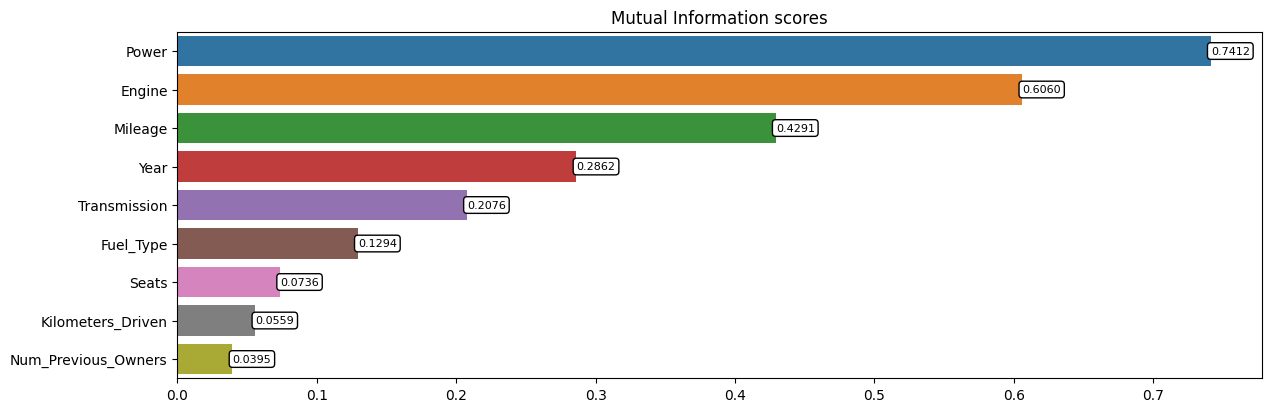

In [75]:
plot_bars(mi_scores, 'Mutual Information scores')

Considering all of our tests, none of our features are clear candidates for rejection. We will not reduce our feature set.

# Modeling framework

### Hold-out set for testing
(stratified sampling using car brand)

In [76]:
train_data, test_data, train_target, test_target = train_test_split(
    data[features], data[TARGET],
    test_size=0.15,
    shuffle=True,
    stratify=data['Brand'],
    random_state=SEED
)

### Evaluation on test set

In [77]:
def evaluate(model):
    global test_data, test_target, TARGET
    
    preds = np.clip(model.predict(test_data), 0, None)
    r2 = r2_score(test_target, preds)
    rmse = mean_squared_error(test_target, preds, squared=False)
    print(f'R2-score: {r2:.4f}, RMSE: {rmse:.4f}\n')
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 4.5))
    ax.set_title("Actual prices vs Predicted prices", fontweight='bold')
    plt.axline((0,0), slope=1, color='black')
    sns.scatterplot(x=test_target, y=preds, ax=ax)
    ax.set_xlim([0, 45])
    ax.set_ylim([0, 45])
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    plt.show()
    
    return preds

### Preprocessing pipeline

In [78]:
imputer = SimpleImputer(strategy='median')
imputing_transform = make_column_transformer(
    (imputer, make_column_selector(dtype_exclude=['object', 'category'])),
    remainder='passthrough'
)
imputing_transform.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('simpleimputer',
                                 SimpleImputer(strategy='median'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdbe17df8b0>)])

In [79]:
target_encoder = TargetEncoder(target_type='continuous', random_state=SEED)
target_encoding_transform = make_column_transformer(
    (target_encoder, make_column_selector(dtype_include=['object', 'category'])),
    remainder='passthrough'
)
target_encoding_transform.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('targetencoder',
                                 TargetEncoder(random_state=2024,
                                               target_type='continuous'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdbe17dfbb0>)])

In [80]:
scaler = StandardScaler()
scaling_transform = make_column_transformer(
    (scaler, make_column_selector(dtype_include=['int64', 'float64'])),
    remainder='passthrough'
)
scaling_transform.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdbe17de7a0>)])

In [81]:
preprocessor = make_pipeline(
    imputing_transform,
    target_encoding_transform,
    scaling_transform  # target-encoded values also scaled 
)

# Base models

### Linear Regression

R2-score: 0.7915, RMSE: 3.5803



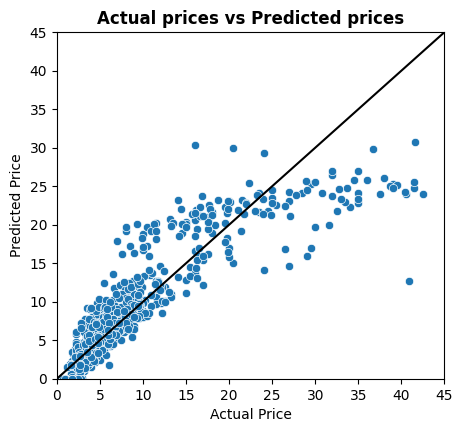

In [82]:
model = make_pipeline(preprocessor, LinearRegression(n_jobs=-1))
model.fit(train_data, train_target)

preds_lr = evaluate(model)

### K-Nearest Neighbors

R2-score: 0.8701, RMSE: 2.8261



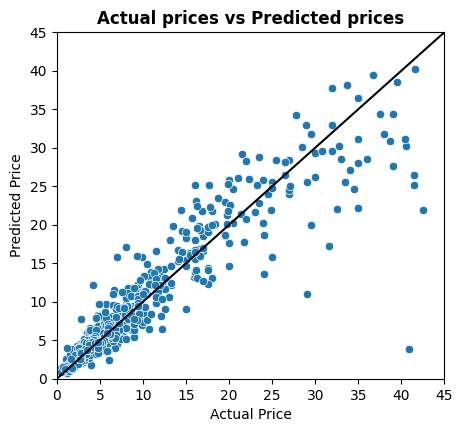

In [83]:
model = make_pipeline(
    preprocessor, 
    KNeighborsRegressor(n_neighbors=7, weights='distance', n_jobs=-1)
)
model.fit(train_data, train_target)

preds_knn = evaluate(model)

### Decision Tree

R2-score: 0.8833, RMSE: 2.6790



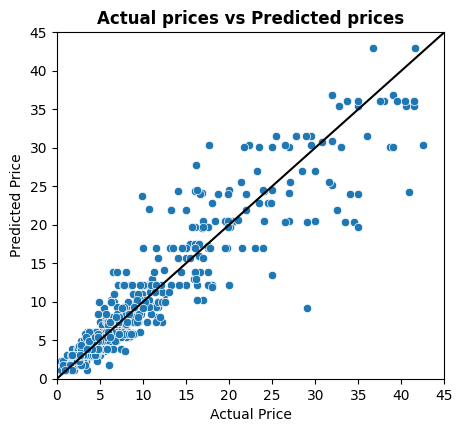

In [84]:
model = make_pipeline(
    preprocessor, 
    DecisionTreeRegressor(max_depth=7, random_state=SEED)
)
model.fit(train_data, train_target)

preds_dt = evaluate(model)

### Random Forest

R2-score: 0.9014, RMSE: 2.4619



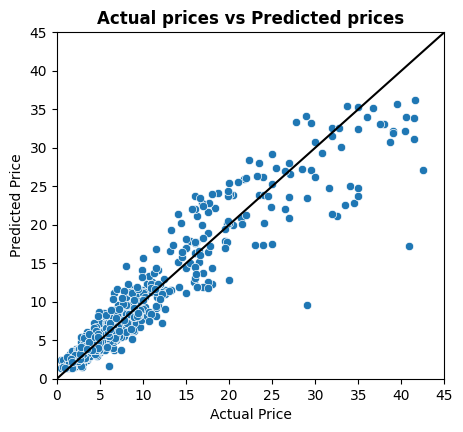

In [85]:
model = make_pipeline(
    preprocessor,
    RandomForestRegressor(
        n_estimators=150,
        max_depth=7,
        random_state=SEED,
        n_jobs=1
    )
)
model.fit(train_data, train_target)
    
preds_rf = evaluate(model)

### AdaBoost

R2-score: 0.9092, RMSE: 2.3629



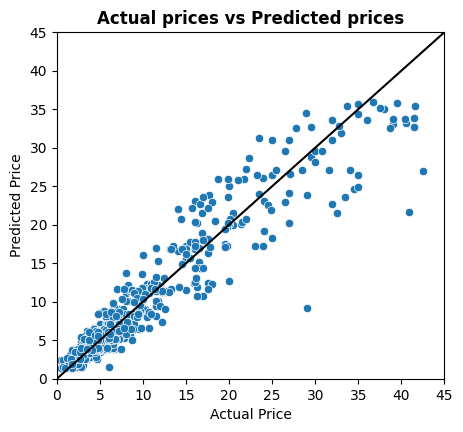

In [86]:
base_estimator = DecisionTreeRegressor(max_depth=7, random_state=SEED)
model = make_pipeline(
    preprocessor,
    AdaBoostRegressor(
        estimator=base_estimator, 
        n_estimators=50, 
        learning_rate=0.05,
        loss='square',
        random_state=SEED
    )
)
model.fit(train_data, train_target)

preds_ada = evaluate(model)

### Multi-layer Perceptron

R2-score: 0.8879, RMSE: 2.6255



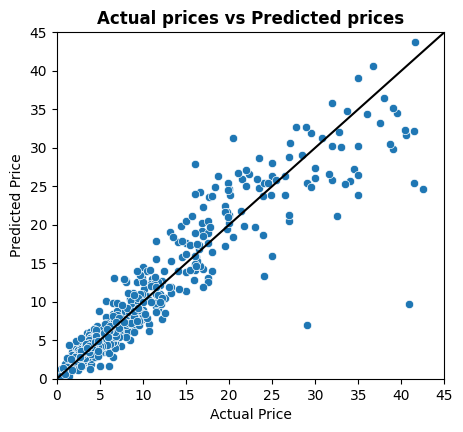

In [87]:
model = make_pipeline(
    preprocessor,
    MLPRegressor(
        hidden_layer_sizes=(32, 32),
        activation='relu',
        solver='adam',
        alpha=1e-5,
        learning_rate_init=1e-2,
        max_iter=1000,
        tol=2e-4,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=25,
        random_state=SEED
    )
)
model.fit(train_data, train_target)

preds_mlp = evaluate(model)

### XGBoost

R2-score: 0.9238, RMSE: 2.1649



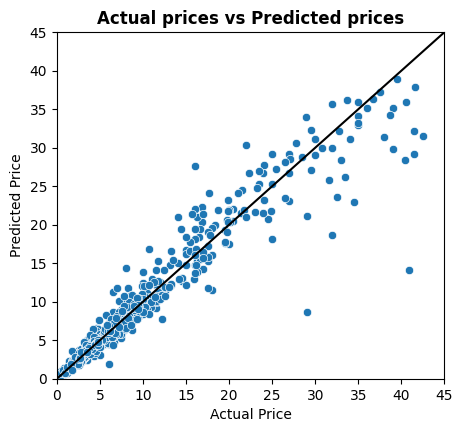

In [88]:
cat_cols = ['Brand', 'Location', 'Fuel_Type', 'Transmission']
train_data[cat_cols] = train_data[cat_cols].astype('category')
test_data[cat_cols] = test_data[cat_cols].astype('category')

model = XGBRegressor(
    booster='gbtree',
    tree_method='hist',
    objective='reg:squarederror',
    learning_rate=0.01,
    n_estimators=2000,
    enable_categorical=True,
    device='cpu',
    verbosity=0,
    seed=SEED
)
model.fit(train_data, train_target)

preds_xgb = evaluate(model)

### Preprocessing + XGBoost

R2-score: 0.9284, RMSE: 2.0987



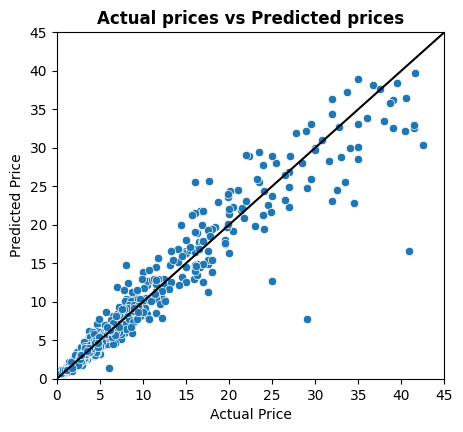

In [89]:
model = make_pipeline(
    preprocessor,
    XGBRegressor(
        booster='gbtree',
        tree_method='hist',
        objective='reg:squarederror',
        learning_rate=0.01,
        n_estimators=2000,
        enable_categorical=True,
        device='cpu',
        verbosity=0,
        seed=SEED
    )
)
model.fit(train_data, train_target)

preds_prexgb = evaluate(model)

### CatBoost

R2-score: 0.9232, RMSE: 2.1734



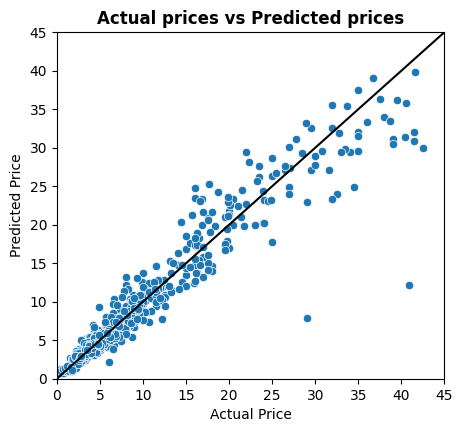

In [90]:
model = CatBoostRegressor(
    loss_function='RMSE',
    iterations=2000,
    learning_rate=0.01,
    task_type='CPU',
    verbose=False,
    random_state=SEED
)
model.fit(train_data, train_target, cat_features=cat_cols)

preds_cb = evaluate(model)

# Ensembling

In [91]:
base_preds = [preds_lr, preds_knn, preds_dt, preds_rf, preds_ada, preds_mlp, preds_xgb, preds_prexgb, preds_cb]

### Simple averaging

In [92]:
mean_preds = np.mean(np.stack(base_preds, axis=-1), axis=1)

In [93]:
r2 = r2_score(test_target, mean_preds)
rmse = mean_squared_error(test_target, mean_preds, squared=False)
print(f'R2-score: {r2:.4f}, RMSE: {rmse:.4f}')

R2-score: 0.9154, RMSE: 2.2804


### Weighted averaging

In [94]:
# manually assigned weights based on observed performance
weights = [0.025, 0.025, 0.05, 0.05, 0.1, 0.05, 0.2, 0.3, 0.2]

In [95]:
weighted_preds = np.dot(np.stack(base_preds, axis=-1), weights)

In [96]:
r2 = r2_score(test_target, weighted_preds)
rmse = mean_squared_error(test_target, weighted_preds, squared=False)
print(f'R2-score: {r2:.4f}, RMSE: {rmse:.4f}')

R2-score: 0.9262, RMSE: 2.1296


# Results summary

| Model | RMSE | R2-Score |
|:-----|:-----:|:-----:
| Linear Regression | 3.5803 | 0.7915  
| K-Nearest Neighbors | 2.8261 | 0.8701  
| Decision Tree | 2.6790 | 0.8833  
| Random Forest | 2.4619 | 0.9014  
| AdaBoost | 2.3629 | 0.9092  
| Multi-layer Perceptron | 2.6255 | 0.8879  
| XGBoost w/o preprocessing | 2.1649 | 0.9238  
| **XGBoost with preprocessing** | **2.0987** | **0.9284**  
| CatBoost w/o preprocessing | 2.1734 | 0.9232
| Simple average ensemble | 2.2804 | 0.9154
| Weighted average ensemble | 2.1296 | 0.9262